![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 022</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">過去コンペの予測ラベル ⇨ Coral-Pytorchで最適化</li>
    <li style = "color:#4c1c84;
                font-size:14px">Ridge</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [1]:
import sys
sys.path.append("../src/utils/iterative-stratification/")
sys.path.append("../src/utils/detoxify")
sys.path.append("../src/utils/coral-pytorch/")

In [2]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import LukeTokenizer, LukeModel, LukeConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification


# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from cuml.svm import SVR as cuml_SVR
from cuml.linear_model import Ridge as cuml_Ridge
import cudf
from detoxify import Detoxify

2022-01-21 05:58:21.772640: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import torch

config = {
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 128,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "022_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": False,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 32,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 64,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 32,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "studio-ousia/luke-base",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-6,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MarginRankingLoss",
}

config = Box(config)
pprint(config)

{'backbone': <Box: {'name': 'studio-ousia/luke-base', 'output_dim': 1}>,
 'entity': 'dataskywalker',
 'environment': 'AWS',
 'epoch': 5,
 'exp_name': '022_exp',
 'loss': 'nn.MarginRankingLoss',
 'margin': 0.5,
 'max_length': 128,
 'n_fold': 5,
 'optimizer': <Box: {'name': 'torch.optim.AdamW', 'params': {'lr': 1e-06}}>,
 'project': 'Jigsaw',
 'root': '/content/drive/MyDrive/kaggle/Jigsaw/raw',
 'scheduler': {'name': 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts',
               'params': <Box: {'T_0': 20, 'eta_min': 0}>},
 'seed': 42,
 'test_loader': {'batch_size': 32,
                 'drop_last': False,
                 'num_workers': 1,
                 'pin_memory': True,
                 'shuffle': False},
 'train_fold': <BoxList: [0, 1, 2, 3, 4]>,
 'train_loader': {'batch_size': 32,
                  'drop_last': True,
                  'num_workers': 1,
                  'pin_memory': True,
                  'shuffle': True},
 'trainer': {'accumulate_grad_batches': 8,
   

In [4]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/022_exp
OUTPUT_DIR is ../data/interim/022_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [5]:
# Seed固定
seed_everything(config.seed)

42

In [6]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [7]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [8]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    explode
</h2>
<br>

In [9]:
with timer("Count less text & more text"):
    less_df = val_df.groupby(["less_toxic"])["worker"].agg("count").reset_index()
    less_df.columns = ["text", "less_count"]

    more_df = val_df.groupby(["more_toxic"])["worker"].agg("count").reset_index()
    more_df.columns = ["text", "more_count"]

<< Count less text & more text >> Start


<< Count less text & more text >> 1.6GB(-0.0GB):0.1sec


In [10]:
val_df_v2 = pd.merge(
    less_df,
    more_df,
    on="text",
    how="outer"
)

val_df_v2["less_count"] = val_df_v2["less_count"].fillna(0)
val_df_v2["more_count"] = val_df_v2["more_count"].fillna(0)
val_df_v2["target"] = val_df_v2["more_count"]-val_df_v2["less_count"]
display(val_df_v2)

,text,less_count,more_count,target
0,\n\nThe comment directly above this one are fr...,1.0,2.0,1.0
1,\n\nwhy should people have to read crap posted...,1.0,8.0,7.0
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,1.0
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,-3.0
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,-2.0
...,...,...,...,...
14246,{{unblock|The reason I used sockpuppets was to...,0.0,3.0,3.0
14247,{{unblock}} BECAUSE BAIL OUT IS THE BEST FUCK...,0.0,3.0,3.0
14248,|Christopher Connor]]. I am off to my daily ma...,0.0,6.0,6.0
14249,}} \n\nSomeone should address this fucking pro...,0.0,1.0,1.0


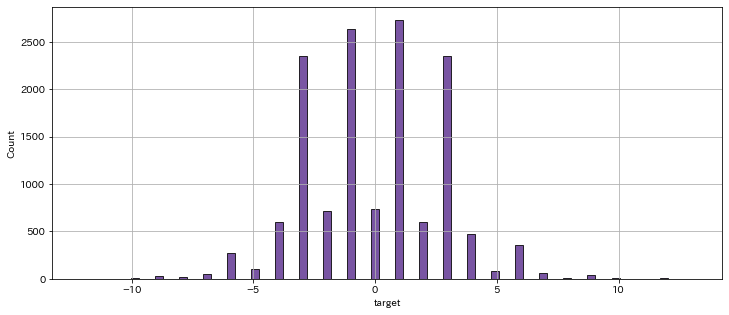

In [11]:
plt.figure(figsize=(12, 5))
sns.histplot(val_df_v2["target"], color="#4c1c84")
plt.grid()
plt.show()

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Detoxify
</h1>
<br>

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Original Label Predict
</h2>
<br>

In [12]:
loaded = torch.load("../data/external/detoxify_ckpt/toxic_original-c1212f89.ckpt")
loaded["config"]["arch"]["args"]

{'num_classes': 6,
 'model_type': 'bert-base-uncased',
 'model_name': 'BertForSequenceClassification',
 'tokenizer_name': 'BertTokenizer'}

In [13]:
huggingface_config_path = '../data/processed/bert-base-uncased/'
detox_model = Detoxify(
    'original', 
    checkpoint="../data/external/detoxify_ckpt/toxic_original-c1212f89.ckpt",
    huggingface_config_path=huggingface_config_path,
    device="cuda"
)
detox_model.predict(val_df_v2["text"].tolist()[0])

{'toxicity': 0.013817166,
 'severe_toxicity': 0.00011941248,
 'obscene': 0.00076001964,
 'threat': 0.00020817625,
 'insult': 0.00080314634,
 'identity_attack': 0.00031358385}

In [14]:
val_df_v2['detoxify_ori_bert_dict'] = val_df_v2['text'].progress_map(lambda line: detox_model.predict(line))
detoxify_df = val_df_v2["detoxify_ori_bert_dict"].apply(pd.Series)
display(detoxify_df.head())

  0%|          | 0/14251 [00:00<?, ?it/s]

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
0,0.013817,0.000119,0.000760,0.000208,0.000803,0.000314
1,0.988867,0.055875,0.889513,0.001117,0.931064,0.017723
2,0.878993,0.006784,0.381441,0.001003,0.668028,0.010523
3,0.608959,0.001044,0.052541,0.001463,0.059024,0.004331
4,0.882861,0.024639,0.583310,0.007645,0.272806,0.248404


In [15]:
val_df_v2 = pd.concat([
    val_df_v2,
    detoxify_df.add_prefix("ori_bert__")
], axis=1)

display(val_df_v2.head())

,text,less_count,more_count,target,detoxify_ori_bert_dict,ori_bert__toxicity,ori_bert__severe_toxicity,ori_bert__obscene,ori_bert__threat,ori_bert__insult,ori_bert__identity_attack
0,\n\nThe comment directly above this one are fr...,1.0,2.0,1.0,"{'toxicity': 0.013817166, 'severe_toxicity': 0...",0.013817,0.000119,0.000760,0.000208,0.000803,0.000314
1,\n\nwhy should people have to read crap posted...,1.0,8.0,7.0,"{'toxicity': 0.98886746, 'severe_toxicity': 0....",0.988867,0.055875,0.889513,0.001117,0.931064,0.017723
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,1.0,"{'toxicity': 0.8789931, 'severe_toxicity': 0.0...",0.878993,0.006784,0.381441,0.001003,0.668028,0.010523
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,-3.0,"{'toxicity': 0.60895926, 'severe_toxicity': 0....",0.608959,0.001044,0.052541,0.001463,0.059024,0.004331
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,-2.0,"{'toxicity': 0.88286126, 'severe_toxicity': 0....",0.882861,0.024639,0.583310,0.007645,0.272806,0.248404


In [16]:
val_df_v2 = val_df_v2.drop("detoxify_ori_bert_dict", axis=1)

In [17]:
display(val_df_v2.head())

,text,less_count,more_count,target,ori_bert__toxicity,ori_bert__severe_toxicity,ori_bert__obscene,ori_bert__threat,ori_bert__insult,ori_bert__identity_attack
0,\n\nThe comment directly above this one are fr...,1.0,2.0,1.0,0.013817,0.000119,0.000760,0.000208,0.000803,0.000314
1,\n\nwhy should people have to read crap posted...,1.0,8.0,7.0,0.988867,0.055875,0.889513,0.001117,0.931064,0.017723
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,1.0,0.878993,0.006784,0.381441,0.001003,0.668028,0.010523
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,-3.0,0.608959,0.001044,0.052541,0.001463,0.059024,0.004331
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,-2.0,0.882861,0.024639,0.583310,0.007645,0.272806,0.248404


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Unbiased
</h2>
<br>

In [18]:
loaded = torch.load("../data/external/detoxify_ckpt/toxic_debiased-c7548aa0.ckpt")
loaded["config"]["arch"]["args"]

{'num_classes': 16,
 'model_type': 'roberta-base',
 'model_name': 'RobertaForSequenceClassification',
 'tokenizer_name': 'RobertaTokenizer'}

In [19]:
detox_model = Detoxify(
    'unbiased', 
    checkpoint="../data/external/detoxify_ckpt/toxic_debiased-c7548aa0.ckpt",
    device="cuda"
)
detox_model.predict(val_df_v2["text"].tolist()[0])

{'toxicity': 0.04638098,
 'severe_toxicity': 6.8517224e-06,
 'obscene': 0.0012877041,
 'identity_attack': 0.00047499713,
 'insult': 0.023260582,
 'threat': 5.9742473e-05,
 'sexual_explicit': 0.00014217675}

In [20]:
val_df_v2['detoxify_unb_roberta_dict'] = val_df_v2['text'].progress_map(lambda line: detox_model.predict(line))
detoxify_df = val_df_v2["detoxify_unb_roberta_dict"].apply(pd.Series)
display(detoxify_df.head())

  0%|          | 0/14251 [00:00<?, ?it/s]

,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.046381,0.000007,0.001288,0.000475,0.023261,0.000060,0.000142
1,0.996821,0.014117,0.766298,0.005401,0.977538,0.001212,0.007697
2,0.963985,0.007209,0.730828,0.006218,0.676747,0.002221,0.019691
3,0.762437,0.002843,0.514118,0.006008,0.148317,0.002122,0.024532
4,0.945681,0.003839,0.774230,0.022131,0.521360,0.000532,0.002330


In [21]:
val_df_v2 = pd.concat([
    val_df_v2,
    detoxify_df.add_prefix("unb_roberta__")
], axis=1)

val_df_v2 = val_df_v2.drop("detoxify_unb_roberta_dict", axis=1)
display(val_df_v2.head())

,text,less_count,more_count,target,ori_bert__toxicity,ori_bert__severe_toxicity,ori_bert__obscene,ori_bert__threat,ori_bert__insult,ori_bert__identity_attack,unb_roberta__toxicity,unb_roberta__severe_toxicity,unb_roberta__obscene,unb_roberta__identity_attack,unb_roberta__insult,unb_roberta__threat,unb_roberta__sexual_explicit
0,\n\nThe comment directly above this one are fr...,1.0,2.0,1.0,0.013817,0.000119,0.000760,0.000208,0.000803,0.000314,0.046381,0.000007,0.001288,0.000475,0.023261,0.000060,0.000142
1,\n\nwhy should people have to read crap posted...,1.0,8.0,7.0,0.988867,0.055875,0.889513,0.001117,0.931064,0.017723,0.996821,0.014117,0.766298,0.005401,0.977538,0.001212,0.007697
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,1.0,0.878993,0.006784,0.381441,0.001003,0.668028,0.010523,0.963985,0.007209,0.730828,0.006218,0.676747,0.002221,0.019691
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,-3.0,0.608959,0.001044,0.052541,0.001463,0.059024,0.004331,0.762437,0.002843,0.514118,0.006008,0.148317,0.002122,0.024532
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,-2.0,0.882861,0.024639,0.583310,0.007645,0.272806,0.248404,0.945681,0.003839,0.774230,0.022131,0.521360,0.000532,0.002330


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Multilingual
</h2>
<br>

In [22]:
detox_model = Detoxify(
    'multilingual', 
    checkpoint="../data/external/detoxify_ckpt/multilingual_debiased-0b549669.ckpt",
    device="cuda"
)
detox_model.predict(val_df_v2["text"].tolist()[0])

{'toxicity': 0.046555452,
 'severe_toxicity': 4.5118286e-05,
 'obscene': 0.000860468,
 'identity_attack': 0.00034021927,
 'insult': 0.016736077,
 'threat': 8.195784e-05,
 'sexual_explicit': 0.00012508762}

In [23]:
val_df_v2['detoxify_mul_xlmroberta_dict'] = val_df_v2['text'].progress_map(lambda line: detox_model.predict(line))
detoxify_df = val_df_v2["detoxify_mul_xlmroberta_dict"].apply(pd.Series)
display(detoxify_df.head())

  0%|          | 0/14251 [00:00<?, ?it/s]

,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.046555,0.000045,0.000860,0.000340,0.016736,0.000082,0.000125
1,0.996775,0.008531,0.691466,0.008615,0.986422,0.002710,0.011015
2,0.949141,0.008072,0.458760,0.059603,0.722148,0.004508,0.007633
3,0.431664,0.001490,0.032777,0.005584,0.078779,0.001206,0.002943
4,0.971955,0.007986,0.803926,0.054271,0.736807,0.003226,0.004089


In [24]:
val_df_v2 = pd.concat([
    val_df_v2,
    detoxify_df.add_prefix("mul_xlmroberta__")
], axis=1)

val_df_v2 = val_df_v2.drop("detoxify_mul_xlmroberta_dict", axis=1)
display(val_df_v2.head())

,text,less_count,more_count,target,ori_bert__toxicity,ori_bert__severe_toxicity,ori_bert__obscene,ori_bert__threat,ori_bert__insult,ori_bert__identity_attack,...,unb_roberta__insult,unb_roberta__threat,unb_roberta__sexual_explicit,mul_xlmroberta__toxicity,mul_xlmroberta__severe_toxicity,mul_xlmroberta__obscene,mul_xlmroberta__identity_attack,mul_xlmroberta__insult,mul_xlmroberta__threat,mul_xlmroberta__sexual_explicit
0,\n\nThe comment directly above this one are fr...,1.0,2.0,1.0,0.013817,0.000119,0.000760,0.000208,0.000803,0.000314,...,0.023261,0.000060,0.000142,0.046555,0.000045,0.000860,0.000340,0.016736,0.000082,0.000125
1,\n\nwhy should people have to read crap posted...,1.0,8.0,7.0,0.988867,0.055875,0.889513,0.001117,0.931064,0.017723,...,0.977538,0.001212,0.007697,0.996775,0.008531,0.691466,0.008615,0.986422,0.002710,0.011015
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,1.0,0.878993,0.006784,0.381441,0.001003,0.668028,0.010523,...,0.676747,0.002221,0.019691,0.949141,0.008072,0.458760,0.059603,0.722148,0.004508,0.007633
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,-3.0,0.608959,0.001044,0.052541,0.001463,0.059024,0.004331,...,0.148317,0.002122,0.024532,0.431664,0.001490,0.032777,0.005584,0.078779,0.001206,0.002943
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,-2.0,0.882861,0.024639,0.583310,0.007645,0.272806,0.248404,...,0.521360,0.000532,0.002330,0.971955,0.007986,0.803926,0.054271,0.736807,0.003226,0.004089


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Original-Small
</h2>
<br>

In [25]:
detox_model = Detoxify(
    'original-small', 
    checkpoint="../data/external/detoxify_ckpt/original-albert-0e1d6498.ckpt",
    device="cuda"
)
detox_model.predict(val_df_v2["text"].tolist()[0])

{'toxicity': 0.01604556,
 'severe_toxicity': 7.370898e-05,
 'obscene': 0.0013387633,
 'threat': 0.00012291719,
 'insult': 0.00046253568,
 'identity_attack': 0.00021790211}

In [26]:
val_df_v2['detoxify_ori_albert_dict'] = val_df_v2['text'].progress_map(lambda line: detox_model.predict(line))
detoxify_df = val_df_v2["detoxify_ori_albert_dict"].apply(pd.Series)
display(detoxify_df.head())

  0%|          | 0/14251 [00:00<?, ?it/s]

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
0,0.016046,0.000074,0.001339,0.000123,0.000463,0.000218
1,0.990454,0.054668,0.866803,0.003593,0.861199,0.012873
2,0.956671,0.019230,0.738978,0.002016,0.706383,0.013581
3,0.589035,0.000580,0.020445,0.000979,0.040902,0.001938
4,0.812644,0.002822,0.556029,0.001586,0.097701,0.002317


In [27]:
val_df_v2 = pd.concat([
    val_df_v2,
    detoxify_df.add_prefix("ori_albert__")
], axis=1)

val_df_v2 = val_df_v2.drop("detoxify_ori_albert_dict", axis=1)
display(val_df_v2.head())

,text,less_count,more_count,target,ori_bert__toxicity,ori_bert__severe_toxicity,ori_bert__obscene,ori_bert__threat,ori_bert__insult,ori_bert__identity_attack,...,mul_xlmroberta__identity_attack,mul_xlmroberta__insult,mul_xlmroberta__threat,mul_xlmroberta__sexual_explicit,ori_albert__toxicity,ori_albert__severe_toxicity,ori_albert__obscene,ori_albert__threat,ori_albert__insult,ori_albert__identity_attack
0,\n\nThe comment directly above this one are fr...,1.0,2.0,1.0,0.013817,0.000119,0.000760,0.000208,0.000803,0.000314,...,0.000340,0.016736,0.000082,0.000125,0.016046,0.000074,0.001339,0.000123,0.000463,0.000218
1,\n\nwhy should people have to read crap posted...,1.0,8.0,7.0,0.988867,0.055875,0.889513,0.001117,0.931064,0.017723,...,0.008615,0.986422,0.002710,0.011015,0.990454,0.054668,0.866803,0.003593,0.861199,0.012873
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,1.0,0.878993,0.006784,0.381441,0.001003,0.668028,0.010523,...,0.059603,0.722148,0.004508,0.007633,0.956671,0.019230,0.738978,0.002016,0.706383,0.013581
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,-3.0,0.608959,0.001044,0.052541,0.001463,0.059024,0.004331,...,0.005584,0.078779,0.001206,0.002943,0.589035,0.000580,0.020445,0.000979,0.040902,0.001938
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,-2.0,0.882861,0.024639,0.583310,0.007645,0.272806,0.248404,...,0.054271,0.736807,0.003226,0.004089,0.812644,0.002822,0.556029,0.001586,0.097701,0.002317


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Linear Regression
</h2>
<br>

In [39]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

ori_cols = [col for col in val_df_v2.columns if "ori_bert__" in col]
unb_cols = [col for col in val_df_v2.columns if "unb_roberta__" in col]
mul_cols = [col for col in val_df_v2.columns if "mul_xlmroberta__" in col]
ori_alb_cols = [col for col in val_df_v2.columns if "ori_albert__" in col]

feature_cols = ori_cols + unb_cols + mul_cols + ori_alb_cols

oof_lr = np.zeros(len(val_df_v2))
oof_ridge = np.zeros(len(val_df_v2))
oof_svr = np.zeros(len(val_df_v2))

skf = StratifiedKFold(n_splits=5,random_state=config.seed)

for fold, (tr_idx, va_idx) in enumerate(skf.split(val_df_v2, val_df_v2["more_count"])):
    
    print("★"*20, f" fold:{fold+1} ", "★"*20)
    X_train = val_df_v2.loc[tr_idx, feature_cols]
    y_train = val_df_v2.loc[tr_idx, "target"]
    
    X_valid = val_df_v2.loc[va_idx, feature_cols]
    y_valid = val_df_v2.loc[va_idx, "target"]
    
    clf = LinearRegression(normalize=True)
    clf.fit(X_train, y_train)
    oof_pred = clf.predict(X_valid)
    oof_lr[va_idx] += oof_pred
    
    clf = Ridge()
    clf.fit(X_train, y_train)
    oof_pred = clf.predict(X_valid)
    oof_ridge[va_idx] += oof_pred
    
    clf = SVR()
    clf.fit(X_train, y_train)
    oof_pred = clf.predict(X_valid)
    oof_svr[va_idx] += oof_pred

★★★★★★★★★★★★★★★★★★★★  fold:1  ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★  fold:2  ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★  fold:3  ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★  fold:4  ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★  fold:5  ★★★★★★★★★★★★★★★★★★★★


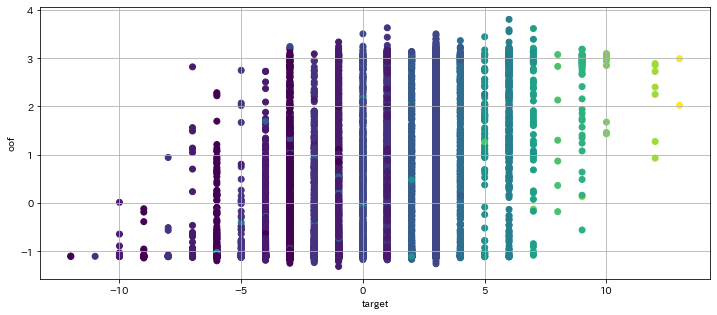

In [40]:
plt.figure(figsize=(12, 5))
plt.scatter(val_df_v2["target"], oof_svr, c=val_df_v2["more_count"])
plt.xlabel("target")
plt.ylabel("oof")
plt.grid()
plt.show()

In [41]:
val_df_v2["oof_lr"] = oof_lr
val_df_v2["oof_ridge"] = oof_ridge
val_df_v2["oof_svr"] = oof_svr

In [42]:
val_df_v2.head()

,text,less_count,more_count,target,ori_bert__toxicity,ori_bert__severe_toxicity,ori_bert__obscene,ori_bert__threat,ori_bert__insult,ori_bert__identity_attack,...,ori_albert__toxicity,ori_albert__severe_toxicity,ori_albert__obscene,ori_albert__threat,ori_albert__insult,ori_albert__identity_attack,oof,oof_lr,oof_ridge,oof_svr
0,\n\nThe comment directly above this one are fr...,1.0,2.0,1.0,0.013817,0.000119,0.000760,0.000208,0.000803,0.000314,...,0.016046,0.000074,0.001339,0.000123,0.000463,0.000218,-1.359178,-1.359178,-1.359302,-1.116059
1,\n\nwhy should people have to read crap posted...,1.0,8.0,7.0,0.988867,0.055875,0.889513,0.001117,0.931064,0.017723,...,0.990454,0.054668,0.866803,0.003593,0.861199,0.012873,1.658795,1.658795,1.656492,2.777011
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,1.0,0.878993,0.006784,0.381441,0.001003,0.668028,0.010523,...,0.956671,0.019230,0.738978,0.002016,0.706383,0.013581,1.237909,1.237909,1.239434,1.413542
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,-3.0,0.608959,0.001044,0.052541,0.001463,0.059024,0.004331,...,0.589035,0.000580,0.020445,0.000979,0.040902,0.001938,-0.062424,-0.062424,-0.066236,-0.445061
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,-2.0,0.882861,0.024639,0.583310,0.007645,0.272806,0.248404,...,0.812644,0.002822,0.556029,0.001586,0.097701,0.002317,0.560313,0.560313,0.573760,1.005448


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Evaluate
</h2>
<br>

In [51]:
OOF_DF = val_df.copy()
OOF_DF = pd.merge(
    OOF_DF,
    val_df_v2[["text", "oof_lr", "oof_ridge", "oof_svr"]],
    left_on="less_toxic",
    right_on="text"
)
OOF_DF = OOF_DF.drop("text", axis=1)
OOF_DF.columns = ["worker", "less_toxic", "more_toxic",
                  "less_pred_lr", "less_pred_ridge", "less_pred_svr", 
                 ]

OOF_DF = pd.merge(
    OOF_DF,
    val_df_v2[["text", "oof_lr", "oof_ridge", "oof_svr"]],
    left_on="more_toxic",
    right_on="text"
)
OOF_DF = OOF_DF.drop("text", axis=1)
OOF_DF.columns = ["worker", "less_toxic", "more_toxic", 
                  "less_pred_lr", "less_pred_ridge", "less_pred_svr", 
                  "more_pred_lr", "more_pred_ridge", "more_pred_svr", 
                 ]

OOF_DF["lr_diff"] = OOF_DF["more_pred_lr"] - OOF_DF["less_pred_lr"]
detoxify_score = OOF_DF[OOF_DF["lr_diff"]>0]["lr_diff"].count()/len(OOF_DF)
print(f"Linear Regression Score: {detoxify_score:.6f}")

OOF_DF["ridge_diff"] = OOF_DF["more_pred_ridge"] - OOF_DF["less_pred_ridge"]
detoxify_score = OOF_DF[OOF_DF["ridge_diff"]>0]["ridge_diff"].count()/len(OOF_DF)
print(f"Ridge Score: {detoxify_score:.6f}")

OOF_DF["svr_diff"] = OOF_DF["more_pred_svr"] - OOF_DF["less_pred_svr"]
detoxify_score = OOF_DF[OOF_DF["svr_diff"]>0]["svr_diff"].count()/len(OOF_DF)
print(f"SVR Score: {detoxify_score:.6f}")

OOF_DF["ensemble_diff"] = OOF_DF[["lr_diff", "ridge_diff", "svr_diff"]].mean(axis=1)
detoxify_score = OOF_DF[OOF_DF["ensemble_diff"]>0]["ensemble_diff"].count()/len(OOF_DF)
print(f"Ensemble Score: {detoxify_score:.6f}")

Linear Regression Score: 0.696127
Ridge Score: 0.696127
SVR Score: 0.695563
Ensemble Score: 0.696493


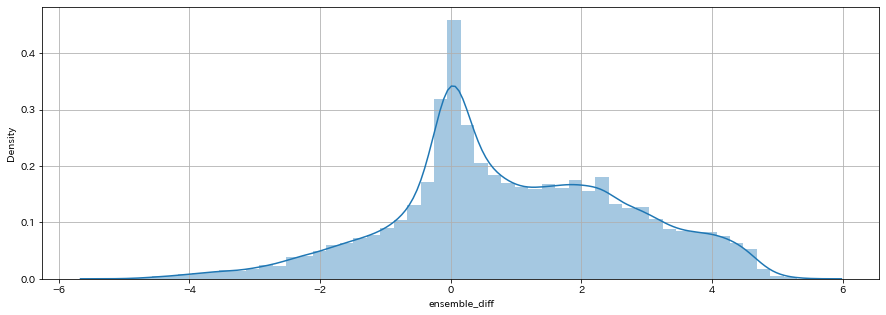

In [52]:
plt.figure(figsize=(15, 5))
sns.distplot(OOF_DF["ensemble_diff"])
plt.grid()
plt.show()

In [57]:
val_df_v2["more_ratio"] = val_df_v2["more_count"]/val_df_v2[["less_count", "more_count"]].sum(axis=1)
val_df_v2[val_df_v2["more_ratio"]>0].sort_values("more_ratio").head()[["text", "less_count", "more_count"]]

,text,less_count,more_count
9454,Support- stops the POV of nationalist editors,11.0,1.0
9051,Please no Wiki-Weirdo posts !,11.0,1.0
8686,Never physical harm. Since you're directly con...,11.0,1.0
832,"Hello \n\nOK, don't try to frighten me with y...",11.0,1.0
9584,"That's pretty damn cool, an old medievil town,...",11.0,1.0


In [63]:
val_df_v2.loc[[9454, 9051, 8686], "text"].tolist()

['Support- stops the POV of nationalist editors   ',
 'Please no Wiki-Weirdo posts !',
 "Never physical harm. Since you're directly contradicting the news sources on this point, I think the research burden lies with you.71.212.36.152  "]

In [65]:
val_df_v2[val_df_v2["more_ratio"]<1].sort_values("more_ratio", ascending=False).head()[["text", "less_count", "more_count"]]

,text,less_count,more_count
9254,STUPID SPANISH CENTRALISTSTUPID SPANISH CENTRA...,1.0,14.0
2228,YOU SUCK \n\nI HATE YOU> YOU CAN FUCK MY ASS ...,1.0,14.0
9443,Stupidhead! Dweeb! How dare you say that! Scor...,1.0,11.0
8598,"Missrain4, I will make a rain of cum on your f...",1.0,11.0
1453,"Ok, what is it \n\nWhy are you such a queer.....",1.0,11.0


In [66]:
val_df_v2.loc[[9254, 2228, 9443], "text"].tolist()

['STUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALISTSTUPID SPANISH CENTRALI